<a href="https://colab.research.google.com/github/NavyaKiran/NYCTaxiFarePrediciton/blob/main/NYC_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
! pip install pyspark -q

In [48]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Trip Analysis") \
    .getOrCreate()

<H1>*DATA EXTRACTION*</H1>

In [49]:
import google.auth
from google.colab import auth

auth.authenticate_user()

In [50]:
# !pip install google-cloud-bigquery
from google.cloud import bigquery
client = bigquery.Client(project = 'navya-weather-data')

query_weather = """
SELECT wban, year, mo, da,
temp, count_temp, dewp, count_dewp, slp, count_slp, stp, count_stp,
visib, count_visib, wdsp, count_wdsp, mxpsd, gust, max, min, prcp, sndp, fog, rain_drizzle, snow_ice_pellets, hail, thunder,
tornado_funnel_cloud
FROM `bigquery-public-data.noaa_gsod.gsod2023` weather
where year = '2023' and mo in ('01', '02')
"""

query_stations = """ select usaf, wban, state, country, call
from `bigquery-public-data.noaa_gsod.stations` stations
where stations.country = 'US' and stations.state = 'NY' and stations.call = 'KNYC'
"""

query_weather_job = client.query(query_weather)
query_stations_job = client.query(query_stations)

In [51]:
weather_data = query_weather_job.to_dataframe(max_results = None)
stations_data = query_stations_job.to_dataframe(max_results = None)

In [52]:
weather_data.shape

(659543, 28)

In [53]:
stations_data.shape

(4, 5)

In [54]:
weather_data.head()

,wban,year,mo,da,temp,count_temp,dewp,count_dewp,slp,count_slp,...,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,99999,2023,01,21,23.5,4,19.1,4,1005.4,4,...,27.5,20.1,0.00,3.5,0,0,0,0,0,0
1,99999,2023,01,26,11.3,4,2.1,4,1002.9,4,...,13.5,10.2,0.00,999.9,0,0,0,0,0,0
2,99999,2023,01,07,28.1,4,23.8,4,1020.8,4,...,30.2,26.6,99.99,999.9,0,0,1,0,0,0
3,99999,2023,02,14,33.1,4,26.6,4,1016.7,4,...,39.7,23.9,99.99,999.9,0,0,1,0,0,0
4,99999,2023,02,23,31.4,4,28.8,4,988.4,4,...,31.6,29.7,0.00,999.9,0,0,0,0,0,0


In [55]:
stations_data.head()

,usaf,wban,state,country,call
0,725033,94728,NY,US,KNYC
1,725060,94728,NY,US,KNYC
2,999999,94728,NY,US,KNYC
3,725053,94728,NY,US,KNYC


In [56]:
weather_nyc = weather_data.merge(stations_data, on = 'wban', how = 'inner')
weather_nyc = weather_nyc[weather_nyc['usaf'] == '725060']

In [57]:
weather_nyc.head()

,wban,year,mo,da,temp,count_temp,dewp,count_dewp,slp,count_slp,...,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,usaf,state,country,call
1,94728,2023,01,21,40.0,24,25.8,24,1017.3,24,...,0,0,0,0,0,0,725060,NY,US,KNYC
5,94728,2023,01,15,33.9,24,18.4,24,1014.7,24,...,0,0,0,0,0,0,725060,NY,US,KNYC
9,94728,2023,02,07,35.9,24,21.5,24,1025.2,24,...,0,0,0,0,0,0,725060,NY,US,KNYC
13,94728,2023,01,03,51.6,24,47.7,24,1017.3,17,...,1,1,0,0,0,0,725060,NY,US,KNYC
17,94728,2023,01,16,35.5,24,10.3,24,1013.1,24,...,0,0,0,0,0,0,725060,NY,US,KNYC


In [58]:
weather_nyc.shape

(59, 32)

In [59]:
weather_nyc.dtypes

wban                     object
year                     object
mo                       object
da                       object
temp                    float64
count_temp                Int64
dewp                    float64
count_dewp                Int64
slp                     float64
count_slp                 Int64
stp                     float64
count_stp                 Int64
visib                   float64
count_visib               Int64
wdsp                     object
count_wdsp               object
mxpsd                    object
gust                    float64
max                     float64
min                     float64
prcp                    float64
sndp                    float64
fog                      object
rain_drizzle             object
snow_ice_pellets         object
hail                     object
thunder                  object
tornado_funnel_cloud     object
usaf                     object
state                    object
country                  object
call    

In [60]:
weather_nyc.shape

(59, 32)

In [61]:
january_data = spark.read.parquet('/content/yellow_tripdata_2023-01.parquet')
february_data = spark.read.parquet('/content/yellow_tripdata_2023-02.parquet')
zone_data = spark.read.option("header", "true").csv('/content/taxi_zones.csv')

In [62]:
january_data.printSchema()
february_data.printSchema()
zone_data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetim

In [63]:
january_data.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [64]:
february_data.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2023-02-01 00:32:53|  2023-02-01 00:34:34|              2|          0.3|         1|                 N|         142|         163|           2|        4.4|  3.5|    0.5|       0.

In [65]:
zone_data.show(10)

+--------+---------------+--------------------+-----------------+--------------------+----------+-------------+
|OBJECTID|     Shape_Leng|            the_geom|       Shape_Area|                zone|LocationID|      borough|
+--------+---------------+--------------------+-----------------+--------------------+----------+-------------+
|       1| 0.116357453189|MULTIPOLYGON (((-...|  0.0007823067885|      Newark Airport|         1|          EWR|
|       2|  0.43346966679|MULTIPOLYGON (((-...| 0.00486634037837|         Jamaica Bay|         2|       Queens|
|       3|0.0843411059012|MULTIPOLYGON (((-...|0.000314414156821|Allerton/Pelham G...|         3|        Bronx|
|       4|0.0435665270921|MULTIPOLYGON (((-...|0.000111871946192|       Alphabet City|         4|    Manhattan|
|       5|0.0921464898574|MULTIPOLYGON (((-...|0.000497957489363|       Arden Heights|         5|Staten Island|
|       6| 0.150490542523|MULTIPOLYGON (((-...|0.000606460984581|Arrochar/Fort Wad...|         6|Staten 

In [66]:
february_data = february_data.withColumnRenamed("Airport_fee", "airport_fee")

In [67]:
february_data.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

In [68]:
yellow_trip_data = january_data.union(february_data)
yellow_trip_data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [69]:
print("The number of rows in the dataframe are",yellow_trip_data.count())
print("The number of columns in the dataframe are",len(yellow_trip_data.columns))
print("The number of rows in the zone dataframe are", zone_data.count())
print("The number of columns in the zone dataframe are", len(zone_data.columns))

The number of rows in the dataframe are 5980721
The number of columns in the dataframe are 19
The number of rows in the zone dataframe are 263
The number of columns in the zone dataframe are 7


In [70]:
yellow_trip_data.registerTempTable("yellow_trip_data")
zone_data.registerTempTable("zone_data")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [71]:
#Now, we combine (join) yellow_trip_data and zone_data

join_query = """select yellow_trip_data.VendorID, TO_DATE(yellow_trip_data.tpep_pickup_datetime) as pickup_date, TO_DATE(yellow_trip_data.tpep_dropoff_datetime) as dropoff_date,
yellow_trip_data.passenger_count, yellow_trip_data.trip_distance, yellow_trip_data.RatecodeID, yellow_trip_data.store_and_fwd_flag,
yellow_trip_data.PULocationID, z1.zone as pickup_zone, z1.borough as pickup_borough, DOLocationID, z2.zone as dropoff_zone,
z2.borough as dropoff_borough,
payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount,
congestion_surcharge, airport_fee
from yellow_trip_data inner join zone_data z1 on yellow_trip_data.PULocationID = z1.LocationID
inner join zone_data z2 on yellow_trip_data.DOLocationID = z2.LocationID
"""

trip_data = spark.sql(join_query)
trip_data.registerTempTable("trip_data")

In [72]:
trip_data.count()

5871100

In [73]:
trip_data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (null

In [74]:
trip_data.show()

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+--------------------+--------------+------------+--------------------+---------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|         pickup_zone|pickup_borough|DOLocationID|        dropoff_zone|dropoff_borough|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+-----------+------------+---------------+-------------+----------+------------------+------------+--------------------+--------------+------------+--------------------+---------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01|

In [75]:
weather_nyc = spark.createDataFrame(weather_nyc)
weather_nyc.registerTempTable("weather_nyc")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [76]:
from pyspark.sql.functions import concat, to_date, lit
weather_nyc=weather_nyc.withColumn("date", to_date(concat(weather_nyc.mo, lit("/"), weather_nyc.da, lit("/"), weather_nyc.year), "MM/dd/yyyy"))
weather_nyc.registerTempTable("weather_nyc")

In [77]:
weather_nyc.printSchema()

root
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: string (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- min: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable = true)
 |-- rain_drizzle: string (nullable = true)
 |-- snow_ice_pellets: string (nullable = true)
 |-- hail: string (nullable = true)
 |-- thunder: string 

In [78]:
weather_nyc.count()

59

In [79]:
join_query_weather = """
SELECT t.VendorID, t.pickup_date, t.dropoff_date, t.passenger_count, t.trip_distance, t.RatecodeID, t.store_and_fwd_flag,
t.PULocationID, t.pickup_zone, t.pickup_borough, t.DOLocationID, t.dropoff_zone,
t.dropoff_borough, t.payment_type, t.fare_amount, t.extra, t.mta_tax, t.tip_amount, t.tolls_amount, t.improvement_surcharge, t.total_amount,
t.congestion_surcharge, t.airport_fee, w.temp, w.dewp, w.slp, w.stp, w.visib, w.wdsp, w.mxpsd, w.gust, w.max, w.min, w.prcp, w.sndp, w.fog, w.rain_drizzle, w.snow_ice_pellets, w.hail, w.thunder, w.tornado_funnel_cloud
FROM trip_data t
LEFT JOIN weather_nyc w ON t.pickup_date = w.date
"""

data = spark.sql(join_query_weather)
data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (null

In [80]:
data.show(10)

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+--------------------+--------------+------------+--------------------+---------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+------+---+-----+----+-----+----+----+----+----+-----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|         pickup_zone|pickup_borough|DOLocationID|        dropoff_zone|dropoff_borough|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|   slp|stp|visib|wdsp|mxpsd|gust| max| min|prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------+---------------+-------------+----------+--------

In [81]:
data.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (null

In [82]:
print("The shape of the dataset is as follows:", (data.count(), len(data.columns)))

The shape of the dataset is as follows: (5871100, 41)


<H1>**DATA CLEANING**</H1>

In [83]:
#begin by checking for null values
from pyspark.sql import functions as fn
data.select([fn.count(fn.when(fn.isnull(col), col)).alias(col) for col in data.columns]).show()

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+-----------+--------------+------------+------------+---------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+---+---+-----+----+-----+----+---+---+----+----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|pickup_zone|pickup_borough|DOLocationID|dropoff_zone|dropoff_borough|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|slp|stp|visib|wdsp|mxpsd|gust|max|min|prcp|sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------+---------------+-------------+----------+------------------+------------+-----------+----------

In [84]:
#drop the rows where columns have null values
data = data.dropna()

In [85]:
data.select([fn.count(fn.when(fn.isnull(col), col)).alias(col) for col in data.columns]).show()

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+-----------+--------------+------------+------------+---------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+---+---+-----+----+-----+----+---+---+----+----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|pickup_zone|pickup_borough|DOLocationID|dropoff_zone|dropoff_borough|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|slp|stp|visib|wdsp|mxpsd|gust|max|min|prcp|sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------+---------------+-------------+----------+------------------+------------+-----------+----------

In [86]:
print("The shape of the dataset is as follows:", (data.count(), len(data.columns)))

The shape of the dataset is as follows: (5725025, 41)


In [87]:
data.describe().show()
#looking at the below result, we see that there are numerous erroneous values.
#Some of them are:
#passenger_count: for taxi's we will consider only 5 seater.
#trip_distance: Let us limit trip distance as within 1 and 100
#total_amount: We will remove the negative values and limit amount to within 1000$

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------+------------------+--------------------+---------------+-------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+-----------------+-------------------+-------------------+-------------------+-------+-------+--------------------+
|summary|          VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|         pickup_zone|pickup_borough|      DOLocationID|        dropoff_zone|dropoff_borough|       payment_type|       fare_amount|            

In [91]:
def filter_dataset():
  filtered_data = data.filter((data['passenger_count'] <= 5) & (data['passenger_count'] > 0))
  filtered_data = filtered_data.filter((data['trip_distance'] >= 1) & (data['trip_distance'] <= 100))
  filtered_data = filtered_data.filter((data['total_amount'] > 3) & (data['total_amount'] <= 200))
  filtered_data.show()
  return filtered_data

#Considering a mid-size SUV/SUV as being the limit, the number of passengers in a car are less than 5
#Also, trip_distance is greater than 0 but less than 100, keeping in mind nyc limits
#the total amount is greater than 3 since base fare in nyc is 3 for yellow cabs and less than 200.

In [93]:
data = filter_dataset()

+--------+-----------+------------+---------------+-------------+----------+------------------+------------+--------------------+--------------+------------+--------------------+---------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----+----+------+---+-----+----+-----+----+----+----+----+-----+---+------------+----------------+----+-------+--------------------+
|VendorID|pickup_date|dropoff_date|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|         pickup_zone|pickup_borough|DOLocationID|        dropoff_zone|dropoff_borough|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|temp|dewp|   slp|stp|visib|wdsp|mxpsd|gust| max| min|prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+--------+-----------+------------+---------------+-------------+----------+--------

In [94]:
data.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------+------------------+--------------------+---------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-------------------+-----------------+-------------------+------------------+-------------------+-------+-------+--------------------+
|summary|          VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|         pickup_zone|pickup_borough|      DOLocationID|        dropoff_zone|dropoff_borough|      payment_type|       fare_amount|             ext

<H3>**EXPLORATORY DATA ANALYSIS**</H3>

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: title={'center': 'Distribution by VendorID'}, ylabel='Frequency'>

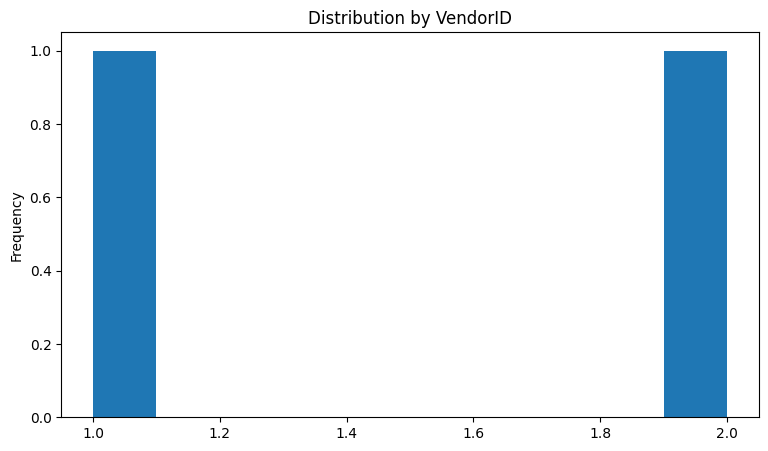

In [105]:
# count plot of VendorID
plt.figure(figsize=(9, 5))

vendors = data.groupBy(['VendorID']).count().toPandas()
vendors['VendorID'].plot(kind = 'hist', title = 'Distribution by VendorID')

#

In [131]:
#!pip install mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.7 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.3-py3-none-any.whl size=20728 sha256=32949fbed85a9d4c0ff604114e6dbd050a133665b222272ddbca50c7c4550fdd
  Stored in directory: /root/.cache/pip/wheels/83/43/92/44f9515471f56877c774a515a2902d3e5484ea1bc7fd412d03
Successfully built mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


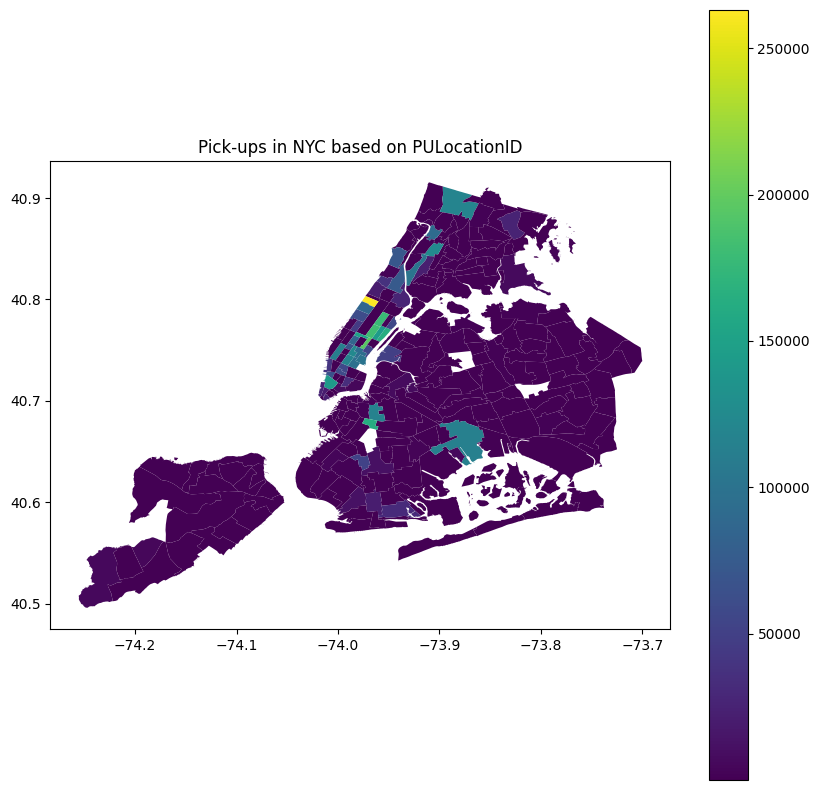

In [133]:
import geopandas as gpd
import mplcursors

pickup_counts = data.groupBy("PULocationID").agg(F.count("*").alias("count")).toPandas()
taxi_zones = gpd.read_file("/content/geo_export_c547245e-03d3-4661-808a-dad9273021d0.shp")
taxi_zones['LocationID'] = taxi_zones.index
merged_data = taxi_zones.merge(pickup_counts, left_on="LocationID", right_on = 'PULocationID')

fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column="count", cmap="viridis", ax=ax, legend = True)
ax.set_title("Pick-ups in NYC based on PULocationID")

texts = [f"LocationID: {loc_id}" for loc_id in merged_data["LocationID"]]
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(texts[sel.target.index]))

plt.show()

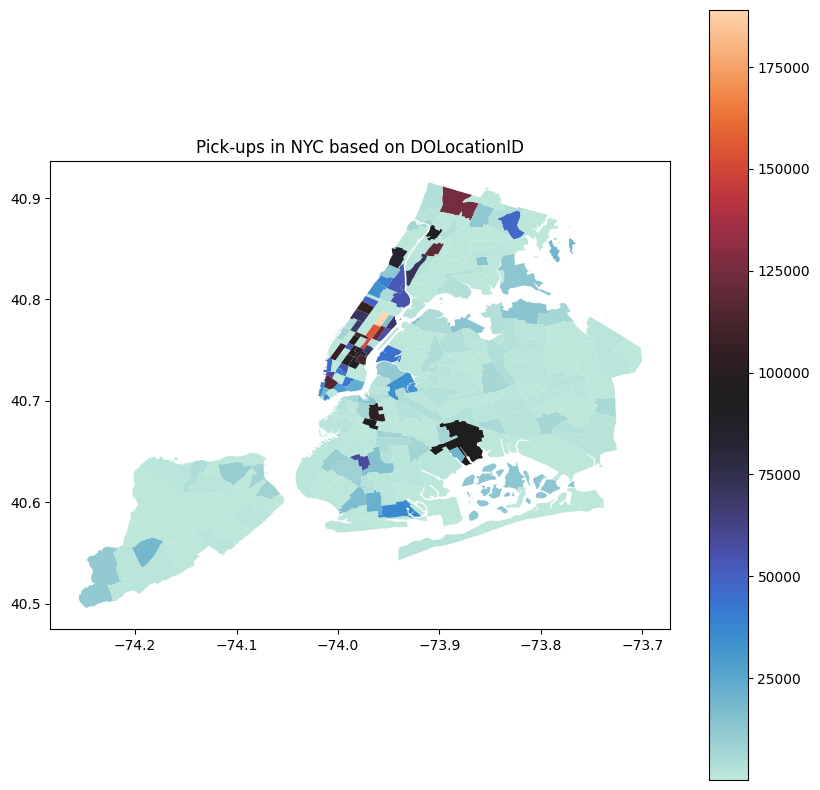

In [137]:
dropoff_counts = data.groupBy("DOLocationID").agg(F.count("*").alias("count")).toPandas()
taxi_zones = gpd.read_file("/content/geo_export_c547245e-03d3-4661-808a-dad9273021d0.shp")
taxi_zones['LocationID'] = taxi_zones.index
merged_data = taxi_zones.merge(dropoff_counts, left_on="LocationID", right_on = 'DOLocationID')

fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column="count", cmap="icefire", ax=ax, legend = True)
ax.set_title("Pick-ups in NYC based on DOLocationID")

texts = [f"LocationID: {loc_id}" for loc_id in merged_data["LocationID"]]
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(texts[sel.target.index]))

plt.show()